In [1]:
# 데이터 조작 라이브러리
import pandas as pd
import numpy as np

In [2]:
from tensorflow import keras

In [3]:
from tensorflow.keras import layers

In [4]:
featuresData = pd.read_csv("../dataset/feature_regression_example.csv")

In [5]:
featuresData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155
...,...,...,...,...,...,...,...,...,...,...,...,...
100,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201648,2016,48,2412,Y,0,Y,0.421888
101,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201649,2016,49,1955,N,4,Y,0.421888
102,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201650,2016,50,1800,N,4,Y,0.352361
103,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201651,2016,51,1173,N,4,Y,0.352361


In [6]:
from tensorflow.python.client import device_lib
# 장치 목록 확인
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18295377291760990069
xla_global_id: -1
]


# A. 데이터 전처리

### A-1. 타입 통합 / 특성 숫자 컬럼 축가

In [7]:
ynDict = { "Y" : 1, "N":0}

In [8]:
featuresData["PROMOTION_YN"] = featuresData.PROMOTION.map(ynDict)

In [9]:
featuresData["HOLIDAY_YN"] = featuresData.HOLIDAY.map(ynDict)

In [10]:
featuresData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTION_YN,HOLIDAY_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,1,0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,1,0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201648,2016,48,2412,Y,0,Y,0.421888,1,1
101,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201649,2016,49,1955,N,4,Y,0.421888,1,0
102,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201650,2016,50,1800,N,4,Y,0.352361,1,0
103,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201651,2016,51,1173,N,4,Y,0.352361,1,0


### A-2. 특성선정 및 데이터 분리

In [13]:
label = ["QTY"]

In [14]:
features = featuresData.select_dtypes(np.number).columns #숫자형 컬럼만 알아서 뽑아줌

In [15]:
features = ["PRO_PERCENT","PROMOTION_YN","HOLIDAY_YN","HCLUS"]

In [16]:
features = list( set ( features ) - set (label) )

In [17]:
print("label: {}".format(label))
print("features: {}".format(features))

label: ['QTY']
features: ['PROMOTION_YN', 'PRO_PERCENT', 'HOLIDAY_YN', 'HCLUS']


In [18]:
stdRatio = 0.8

In [19]:
stdIndex = int(featuresData.shape[0] * stdRatio)
stdIndex

84

In [20]:
stdYearWeek = featuresData.loc[stdIndex].YEARWEEK

In [21]:
stdYearWeek

201632

In [22]:
trainingDataFeatures = featuresData.loc[ featuresData.YEARWEEK < stdYearWeek , features ]
trainingDataLabel = featuresData.loc[ featuresData.YEARWEEK < stdYearWeek , label]
testDataFeatures = featuresData.loc[ featuresData.YEARWEEK >= stdYearWeek , features ]
testDataLabel = featuresData.loc[ featuresData.YEARWEEK >= stdYearWeek , label]

In [23]:
print(trainingDataFeatures.shape)
print(trainingDataLabel.shape)
print(testDataFeatures.shape)
print(testDataLabel.shape)

(84, 4)
(84, 1)
(21, 4)
(21, 1)


### B. 모델 생성/훈련

In [24]:
from sklearn import tree
from tensorflow.keras import Sequential #내가 layer을 한층한층 쌓겠다.
from tensorflow.keras.layers import Dense # 동그라미 전체 연결시킨다.

In [25]:
inputShape = trainingDataFeatures.loc[0].shape  #지금 현재 features가 7개있음을 의미
inputShape

(4,)

In [26]:
model = Sequential() #모델 초기화

In [27]:
# 7
# 7*8 + 8 = 56+8 = 64
model.add( Dense( units=8, activation="relu", input_shape=inputShape) )
# 8*8  + 8 = 64 + 8 =72
model.add( Dense( units=8, activation="relu") )
# 8*1 + 1 = 9
model.add( Dense( units=1, activation="relu") )

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


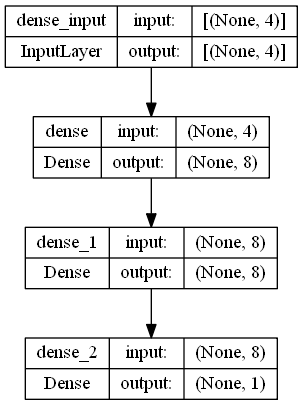

In [29]:
# graphviz 라이브러리 필요
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', 
           show_shapes=True, 
           show_layer_names=True)

In [30]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [31]:
model.compile(optimizer="adam",
              loss= "mean_squared_error",
              metrics=["mean_absolute_error"] ) # compile의 기능은 교수학습방법을 배치시키고, 동그라미에 결과값에 대한 지표(너가 얼마나 틀렸는지?빼기를 할껀지? mse를 할껀지? 지표를 지정을 해준다)

### 모델훈련

In [32]:
trainingDataFeatures.shape


(84, 4)

In [33]:
# 에포크는 전체 문항(84)을 다 봤을때 1epoch라고 한다. Batch_size = 32라면 84문항을 한꺼번에 다 돌리는것이 아니라 32개만 실제 문제지를 대입해보고 전체 weight와bias를 업데이트 한다. 
# 그래서 1개의 에포크에 weight + bias가 3번 업데이트 하게 된다. epochs=500번이면 w+b가 500번이 아니라 1500번 업데이트 한다.

In [34]:
# overfitting = Validation이 없으면 1000번 혹은 10000번을 돌리면 정확도가 100%가 될수밖에 없음.이러한 현상을 오버피팅이라고 함. 정확도는 100%가 되지만 쓸수 없는 모델이 된다.

In [35]:
# 에포크가 한번 넘어갈때 마다(84개문항) 60개를 가지고 학습시키고 24개로 테스트(Validation)를 진행.왜냐면 내가 정답지랑 문제지만 가지고 1억번을 돌리면 정확도가 무조건 100%를 찍을 수 밖에 없는 구조이기때문에 에포크 한번 넘어갈때마다

### B-5. 훈련

In [39]:
history = model.fit(x=trainingDataFeatures,
          y=trainingDataLabel,
          batch_size=32,
          epochs=500,
          validation_split=0.2)

Epoch 1/500
3/3 [==============================] - 0s 40ms/step - loss: 367088.3750 - mean_absolute_error: 424.5563 - val_loss: 247238.2656 - val_mean_absolute_error: 425.7366
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 367004.0625 - mean_absolute_error: 424.3683 - val_loss: 246944.1250 - val_mean_absolute_error: 425.1209
Epoch 3/500
3/3 [==============================] - 0s 21ms/step - loss: 366930.3438 - mean_absolute_error: 424.0835 - val_loss: 246649.6875 - val_mean_absolute_error: 424.5005
Epoch 4/500
3/3 [==============================] - 0s 19ms/step - loss: 366865.2188 - mean_absolute_error: 423.8850 - val_loss: 246394.8281 - val_mean_absolute_error: 423.9706
Epoch 5/500
3/3 [==============================] - 0s 22ms/step - loss: 366674.3750 - mean_absolute_error: 423.5606 - val_loss: 246212.5000 - val_mean_absolute_error: 423.6117
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 366536.6875 - mean_absolute_error: 423.3707 - va

### 예측

In [40]:
features

['PROMOTION_YN', 'PRO_PERCENT', 'HOLIDAY_YN', 'HCLUS']

In [41]:
inHoliday = 1
inHclus = 1
inPro = 1
inPropercent = 0.5

In [ ]:
from sklearn import neural_network

In [44]:
testDf = pd.DataFrame( [ [ inHoliday, inHclus, inPro, inPropercent] ] )

In [45]:
model.predict(testDf)

1/1 [==============================] - 0s 90ms/step


array([[2310.6602]], dtype=float32)

In [ ]:
# 모델은 모델파일과 weight파일을 따로 저장한다.